In [1]:
from google.colab import drive
drive.mount('/content/drive/')

from drive.MyDrive.kursach import helpers
path = 'drive/MyDrive/kursach/'

Mounted at /content/drive/


# Подготовка

In [2]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
     |████████████████████████████████| 376 kB 23.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d9559dbc7c0e8d68cf1320676a0050338e2ea822526c310010c22d691bb23ffa
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=7e38d9a8a2b6fee8a13ca71545453616380de862ffb5e1ce3cba5d7c5bdab823
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 102 kB 5.7 MB/s 
     |████████████████████████████████| 47.6 MB 1.4 MB/s 
albumentations==1.1.0 is successfully installed


In [4]:
import albumentations as albu
import copy
import cv2
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn import model_selection
import torch
from torch import nn
from torch.utils import data

In [5]:
rand = 51
np.random.seed(rand)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
im_medseg, mk_medseg, im_radio, mk_radio = helpers.load_datasets(path, size=(256, 256))

Added drive/MyDrive/kursach/raw-data-kaggle/images_medseg.npy, shape (1, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_medseg.npy, shape (4, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/images_radiopedia.npy, shape (1, 829, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_radiopedia.npy, shape (4, 829, 256, 256)


In [9]:
gc.collect()

134

# Основные классы и функции

In [10]:
class Dataset(data.Dataset):
    def __init__(self, X, y, augmentations=None):
        X = X.reshape(-1, 1, X.shape[1], X.shape[2]).astype(np.float32)
        X = (X - X.min())
        X = X / X.max()
        
        self.X = X
        self.y = y
        self.augmentations = augmentations

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, i):
        x_el, y_el = copy.deepcopy(self.X[i]), copy.deepcopy(self.y[i])
        if self.augmentations is not None:
          sample = self.augmentations(image=x_el[0], mask=y_el)
          x_el[0] = sample['image']
          y_el = sample['mask']

        x_el = torch.from_numpy(x_el).to(device)
        y_el = torch.from_numpy(y_el.astype(np.int64)).to(device)

        return x_el, y_el

def get_loader(dataset, batch=64):
  return data.DataLoader(dataset, batch_size=batch)

def prepare_datasets(X, y):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, random_state=rand)
  train = Dataset(X_train, y_train, train_transform)
  test = Dataset(X_test, y_test, test_transform)
  return train, test

In [11]:
class Network:
    def __init__(self, model, loss):
        self.model = model.to(device)
        self.best_model = copy.deepcopy(model)
        self.loss = loss
        self.best_loss = 1e10
        self.optim = torch.optim.Adam(self.model.parameters())
        self.loss_history = []

    def fit(self, data, epochs=50, verbose=False, no_improvements_iter=-1):
      data = get_loader(data)
      no_improvements = 0
      for i in range(epochs):
        total_loss = 0
        for X, y in data:
          pred = self.model(X)
          loss = self.loss(pred, y)
          total_loss += loss.detach().to('cpu').item()

          self.optim.zero_grad()
          loss.backward()
          self.optim.step()

        if verbose:
          print(f'Epoch {i}, loss {total_loss}')
        self.loss_history.append(total_loss)

        if total_loss < self.best_loss and not math.isclose(total_loss, self.best_loss):
          self.best_loss = total_loss
          self.best_model = copy.deepcopy(self.model)
          no_improvements = 0
        else:
          no_improvements += 1
          print(f'No improvements for {no_improvements} epochs')

        if no_improvements_iter != -1 and no_improvements >= no_improvements_iter:
          break

      self.model = copy.deepcopy(self.best_model)

    def fit_best(self, train, epochs=50, test_metric='accuracy', test_args=(),
                 train_ratio=0.8, reshuffle_iter=3, no_improvements_iter=5):
      size = len(train)
      lengths = [int(size * train_ratio), size - int(size * train_ratio)]
      best_model = None
      best_score = 0.
      no_improvements = 0

      for i in range(epochs):
        print(f'Epoch {i}')
        if i % reshuffle_iter == 0:
          cur_train, cur_test = torch.utils.data.random_split(train, lengths)
        # train phase
        self.fit(cur_train, epochs=1)
        # test phase
        score = self.test(cur_test, test_metric, *test_args)
        if score > best_score:
          best_score = score
          best_model = copy.deepcopy(self.model)
          print(f'Improved score: {best_score}')
          no_improvements = 0
        else:
          no_improvements += 1

        if no_improvements >= no_improvements_iter:
          break

      self.model = best_model


    def test(self, data, metric, *args):
      data = get_loader(data)
      size = len(data.dataset)
      num_batches = len(data)
      total_metric = 0.

      with torch.no_grad():
        for X, y in data:
          pred = self.model(X).argmax(1)
          if metric == 'accuracy':
            total_metric += self._accuracy(pred, y)
          elif metric == 'iou':
            total_metric += self._iou(pred, y, args[0])

      if metric == 'accuracy':
        total_metric /= size
      elif metric == 'iou':
        total_metric /= num_batches

      return total_metric

    def _accuracy(self, y_pred, y_true):
      im_size = y_pred.shape[1] * y_pred.shape[2]
      return (y_pred == y_true).type(torch.float).sum().item() / im_size

    def _iou(self, y_pred, y_true, class_label):
      y_pred = y_pred == class_label
      y_true = y_true == class_label
      intersection = y_pred & y_true
      union = y_pred | y_true
      return intersection.type(torch.float).sum().item() / union.type(torch.float).sum().item()

In [12]:
def create_network(n_classes):
  return Network(smp.Unet(in_channels=1, classes=n_classes, activation='softmax'),
                 nn.CrossEntropyLoss())

# Аугментации

Ниже можно видеть набор аугментаций, с которыми у меня получилось добиться наилучшего результата.

In [13]:
train_transform = albu.Compose([
    albu.VerticalFlip(p=0.5),
    albu.OneOf([
    albu.ShiftScaleRotate(rotate_limit=15, shift_limit=0.05, scale_limit=0.05,
                          p=0.5, border_mode=cv2.BORDER_REPLICATE),
    albu.GridDistortion(p=0.5)
    ], p=0.3),
    albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5), 
])

test_transform = None

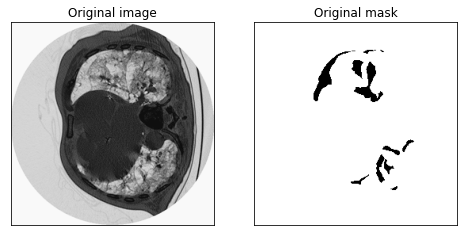

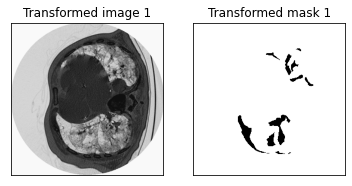

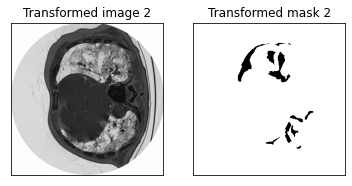

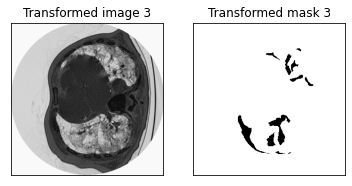

In [14]:
# Visualize transformations

X = im_medseg[0, 0].reshape((1, 256, 256))
y = mk_medseg[0, 0].reshape((1, 256, 256))

dataset = Dataset(X, y, train_transform)

helpers.show_im_row(np.vstack((X, y)), size=3,
                    titles=['Original image', 'Original mask'])

for i in range(3):
  x_el, y_el = dataset[0]
  x_el, y_el = x_el.cpu().numpy(), y_el.cpu().numpy()
  helpers.show_im_row(np.vstack((x_el, y_el.reshape(1, 256, 256))), size=3,
                      titles=[f'Transformed image {i+1}', f'Transformed mask {i+1}'])

# Классифицируем

In [15]:
X = np.concatenate((im_medseg[0], im_radio[0]), axis=0)
y = np.concatenate((mk_medseg, mk_radio), axis=1)
y = y.argmax(0)
X.shape, y.shape

((929, 256, 256), (929, 256, 256))

In [23]:
train, test = prepare_datasets(X, y)
model = create_network(4)

In [24]:
model.fit(train, epochs=150, verbose=True, no_improvements_iter=5)

Epoch 0, loss 13.543443858623505
Epoch 1, loss 10.518327295780182
Epoch 2, loss 9.645690679550171
Epoch 3, loss 9.412441611289978
Epoch 4, loss 9.3322993516922
Epoch 5, loss 9.293494939804077
Epoch 6, loss 9.25965303182602
Epoch 7, loss 9.231939136981964
Epoch 8, loss 9.21181869506836
Epoch 9, loss 9.19782692193985
Epoch 10, loss 9.180323719978333
Epoch 11, loss 9.162461161613464
Epoch 12, loss 9.15363597869873
Epoch 13, loss 9.143113136291504
Epoch 14, loss 9.130690336227417
Epoch 15, loss 9.121414959430695
Epoch 16, loss 9.120747983455658
Epoch 17, loss 9.115119874477386
Epoch 18, loss 9.131428956985474
No improvements for 1 epochs
Epoch 19, loss 9.13054484128952
No improvements for 2 epochs
Epoch 20, loss 9.114664196968079
Epoch 21, loss 9.102318286895752
Epoch 22, loss 9.097101509571075
Epoch 23, loss 9.089651882648468
Epoch 24, loss 9.084701657295227
Epoch 25, loss 9.085921168327332
No improvements for 1 epochs
Epoch 26, loss 9.08887255191803
No improvements for 2 epochs
Epoch 27,

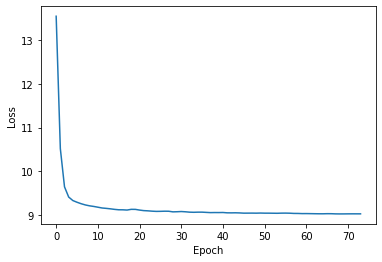

In [25]:
helpers.plot_loss(model)

In [26]:
test_report = '{epochs} epochs\nLoss: {loss}\nAccuracy: {accuracy}\n'
accuracy = model.test(test, 'accuracy')
test_report = test_report.format(epochs=len(model.loss_history),
                                 loss=model.best_loss,
                                 accuracy=accuracy)

for i in range(4):
  test_report += f'{helpers.LABELS[i]} IoU: {model.test(test, "iou", i)}\n'

print(test_report)

74 epochs
Loss: 9.026863932609558
Accuracy: 0.9898983534946236
Ground Glass IoU: 0.7004336729537092
Consolidation IoU: 0.5051023906131439
Lungs Other IoU: 0.9447843982706373
Background IoU: 0.994843232074223



Видим, что получилось значительно улучшить результат по сравнению с изначальной моделью.

In [27]:
label_pairs = [('True ' + label, 'Predicted ' + label)
               for label in helpers.LABELS]
# flatten label pairs
labels = [label for pair in label_pairs for label in pair]

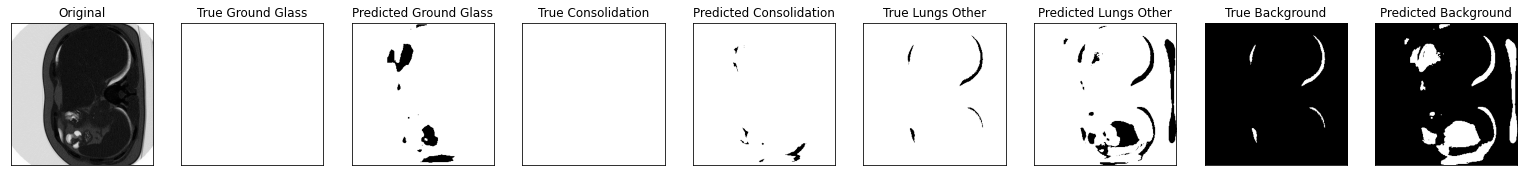

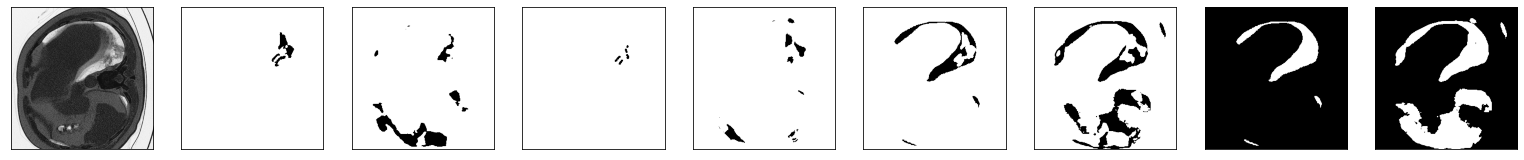

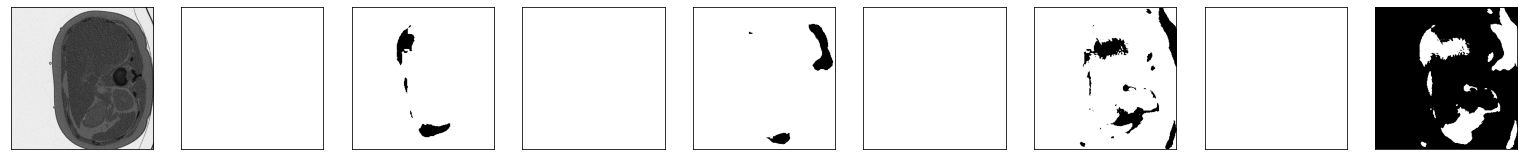

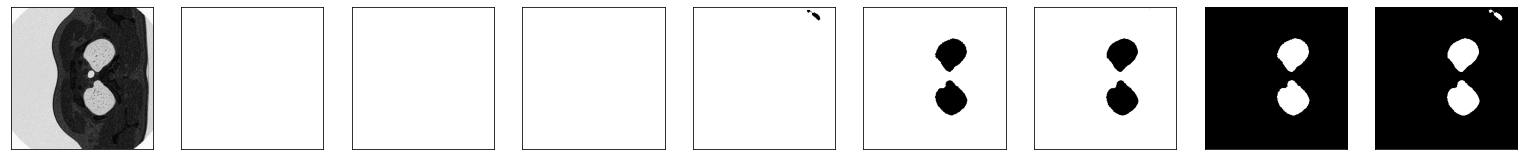

In [28]:
for i in range(4):
  sample, true_answer = test[i]
  pred_answer = model.model(sample.reshape(1, 1, sample.shape[1], -1)).argmax(1)
  images = [sample[0]]
  for j in range(4):
    images += [true_answer == j, (pred_answer == j)[0]]
  images = [im.cpu().detach().numpy() for im in images]
  titles = ['Original'] + labels if i == 0 else None
  helpers.show_im_row(np.array(images), size=3, titles=titles)

In [29]:
torch.save(model.model.state_dict(), path + 'albu-model')
drive.flush_and_unmount()